In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from numbers import Number
from typing import Optional
from numpy.typing import ArrayLike

from functools import reduce

In [2]:
def _df_colors(val):
    if isinstance(val, bool) and val is False:
        color = "red"
    elif isinstance(val, bool) and val is True:
        color = "limegreen"
    elif isinstance(val, Number):
        # color = "gold"
        color = "mediumspringgreen"
    else:
        color = "cornflowerblue"
    return "color: %s" % color

In [3]:
def cols2drop(corr_df, threshold=0.9) -> list[str]:
    corr_df = corr_df.abs()
    mask = np.triu(np.ones_like(corr_df, dtype=bool))
    tri_corr = corr_df.mask(mask)
    to_drop = [c for c in tri_corr.columns if any(tri_corr[c] > threshold)]
    return to_drop, mask

In [4]:
emo2num = {'С': 1,
           'О': 2,
           'Н': 3,
           'Ж': 4,
           'У': 5,
           'Р': 6,
           'Г': 7,
           'Б': 8,
           'З': 9,
           'В': 10}

num2emo = {val: key for key, val in emo2num.items()}

letter2emo = {
"Г": "грусть",
"З": "злость",
"Р": "радость",
"У": "удивление",
"В": "волнение",
"Ж": "раздражение",
"Н": "недовольство",
"О": "обида",
"Б": "обречённость",
"С": "страх"
}

# ML

In [5]:
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

In [6]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay#, multilabel_confusion_matrix
from sklearn.inspection import permutation_importance

In [7]:
std_scaler = StandardScaler()

In [8]:
def print_metrics(y_preds: ArrayLike, 
                  y: ArrayLike, 
                  y_probs: Optional[ArrayLike] = None
) -> None:
    print(f'MSE: {mean_squared_error(y_preds, y)}')
    print(f"Accuracy: {accuracy_score(y_preds, y)}")
    print(f"F-score: {f1_score(y, y_preds, average='weighted')}")
    if y_probs is not None: 
        print(f"ROC-AUC: {roc_auc_score(y, y_probs, multi_class='ovr')}")

In [9]:
basic_metrics_DF = pd.read_csv("basic_metrics_DF.csv")
pos_DF = pd.read_csv("pos_DF.csv")
Ngrams_DF = pd.read_csv("Ngrams_DF.csv")
gramm_DF = pd.read_csv("gramm_DF.csv")
emotion_DF = pd.read_csv("emotion_DF.csv")
syntax_DF = pd.read_csv("syntax_DF.csv")
zipf_DF = pd.read_csv("zipf_DF.csv")

In [10]:
data_frames = [basic_metrics_DF, pos_DF, Ngrams_DF, gramm_DF, emotion_DF, syntax_DF, zipf_DF]

In [11]:
wholeDF = reduce(lambda left,right: pd.merge(left, right, how='outer'), data_frames)
# pd.merge(basic_metrics_DF, gramm_DF, on="IDs") == pd.merge(basic_metrics_DF, gramm_DF)
wholeDF = wholeDF.drop(wholeDF.columns[0], axis=1)
wholeDF.head().style.map(_df_colors)

,IDs,Primary Emotion,Emotion Class,V_lemma,syl,word_long,word_long_pr,ASW,ACW,lemma_long,lemma_long_pr,TTR_lemma,YuleI_word,YuleK_lemma,YuleI_lemma,Func_word_pr,Verb_pr,Noun_pr,Adj_pr,Pron_pr,Autosem_pr,Nouns_pr,NVR,Cconj_pr,Sconj_pr,Adjs_pr,Prtf_pr,Prts_pr,Npro_pr,Pred_p,Grnd_pr,Infn_pr,Numr_pr,Prcl_pr,Prep_pr,Comp_pr,Pos_ngrams_1_pr,Pos_ngrams_2_pr,Pos_ngrams_3_pr,Pos_ngrams_4_pr,Pos_ngrams_5_pr,Pos_ngrams_6_pr,Pos_ngrams_7_pr,Pos_ngrams_8_pr,Pos_ngrams_9_pr,Pos_ngrams_10_pr,Pos_ngrams_11_pr,Pos_ngrams_12_pr,Dyn_Stat,Gen_pr,Ablt_pr,Adjf_pr,Neut_pr,Inan_pr,1P_pr,3P_pr,Pres_pr,Futr_pr,Past_pr,Impf_pr,Perf_pr,Pssv_prtf_pr,Pssv_prts_pr,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,Acl_pr,Acl:relcl_pr,Advcl_pr,Advmod_pr,Amod_pr,Appos_pr,Aux:pass_pr,Ccomp_pr,Compound_pr,Conj_pr,Cop_pr,Csubj_pr,Csubj:pass_pr,Discourse_pr,Mark_pr,Nsubj_pr,Nsubj:pass_pr,Nummod_pr,Orphan_pr,Parataxis_pr,Xcomp_pr,0,1,2,3,4,5,6,7,8
0,0107635181_00__00-channel-0-number-004_18310,С,1,6,11,0,0.000000,1.833333,4.500000,0,0.000000,1.000000,0.000000,0.000000,0.000000,0.166667,0.333333,0.333333,0.000000,0.166667,0.666667,0.333333,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.166667,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.166667,0.000000,0.333333,0.000000,0.333333,0.333333,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,2,1,2,0,1
1,0107635181_00__00-channel-0-number-005_22100,С,1,10,22,2,0.200000,2.200000,4.900000,1,0.100000,0.909091,0.000000,0.000000,0.000000,0.090909,0.272727,0.090909,0.000000,0.363636,0.454545,0.090909,0.333333,0.090909,0.000000,0.000000,0.000000,0.000000,0.181818,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.090909,0.000000,0.090909,0.090909,0.181818,0.181818,0.090909,0.000000,0.181818,0.090909,0.000000,0.000000,1,1,0,1,0,1,1,0,0,1,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,0,0,0,0,0,2,3,3,1
2,0107635181_00__00-channel-0-number-006_26690,С,1,11,17,0,0.000000,1.416667,3.583333,0,0.000000,0.916667,40.333333,247.933884,40.333333,0.416667,0.083333,0.166667,0.166667,0.083333,0.500000,0.333333,2.000000,0.000000,0.000000,0.000000,0.083333,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.083333,0.250000,0.083333,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.000000,0,0,1,1,0,2,0,0,0,0,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,0,0,0,0,0,4,3,2,3
3,0107636961_00__00-channel-0-number-009_34800,С,1,7,15,1,0.125000,1.875000,4.125000,0,0.000000,0.875000,16.333333,612.244898,16.333333,0.000000,0.375000,0.000000,0.000000,0.500000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.125000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.125000,0.000000,0.125000,0.125000,0.125000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,True,0,0,0,1,1,1,2,2,0
4,0107638181_00__00-channel-0-number-018_59400,С,1,5,11,1,0.200000,2.200000,4.800000,1,0.200000,0.833333,0.000000,0.000000,0.000000,0.166667

In [12]:
wholeDF = wholeDF.drop_duplicates(subset=["IDs"])
wholeDF.shape

(3498, 103)

In [13]:
wholeDF.describe().style.map(_df_colors)

,Emotion Class,V_lemma,syl,word_long,word_long_pr,ASW,ACW,lemma_long,lemma_long_pr,TTR_lemma,YuleI_word,YuleK_lemma,YuleI_lemma,Func_word_pr,Verb_pr,Noun_pr,Adj_pr,Pron_pr,Autosem_pr,Nouns_pr,NVR,Cconj_pr,Sconj_pr,Adjs_pr,Prtf_pr,Prts_pr,Npro_pr,Pred_p,Grnd_pr,Infn_pr,Numr_pr,Prcl_pr,Prep_pr,Comp_pr,Pos_ngrams_1_pr,Pos_ngrams_2_pr,Pos_ngrams_3_pr,Pos_ngrams_4_pr,Pos_ngrams_5_pr,Pos_ngrams_6_pr,Pos_ngrams_7_pr,Pos_ngrams_8_pr,Pos_ngrams_9_pr,Pos_ngrams_10_pr,Pos_ngrams_11_pr,Pos_ngrams_12_pr,Dyn_Stat,Gen_pr,Ablt_pr,Adjf_pr,Neut_pr,Inan_pr,1P_pr,3P_pr,Pres_pr,Futr_pr,Past_pr,Impf_pr,Perf_pr,Pssv_prtf_pr,Pssv_prts_pr,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,0,1,2,3,4,5,6,7,8
count,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000
mean,7.157233,7.434820,15.953688,0.890509,0.118074,2.021182,4.736755,0.548599,0.073352,0.923982,6.381209,389.845688,7.281426,0.244306,0.194304,0.177715,0.043288,0.191970,0.551548,0.221003,0.742405,0.040227,0.019396,0.004108,0.001493,0.002129,0.132594,0.017907,0.000291,0.030642,0.034276,0.108775,0.083814,0.002297,0.015220,0.024574,0.014528,0.032146,0.020770,0.003590,0.008594,0.000060,0.000036,0.000515,0.000442,0.000210,3.351302,0.059949,0.009210,0.067147,0.016823,0.133034,0.027893,0.041693,0.067913,0.014212,0.051621,0.089713,0.053827,0.000852,0.002129,0.065752,0.079188,0.052601,0.119783,0.026301,0.289880,0.437679,0.117782,0.046312,0.318754,0.000572,0.016581,0.078902,0.301029,0.575472,1.608634,2.590051,2.264151,0.330475
std,3.188373,2.802917,6.537687,0.952859,0.132992,0.452713,1.131979,0.751747,0.105812,0.103023,14.168513,981.157282,14.018270,0.148956,0.132548,0.147957,0.085842,0.140352,0.195792,0.178996,0.883415,0.071032,0.050713,0.026044,0.016518,0.018603,0.120363,0.053294,0.005844,0.064609,0.109309,0.123608,0.098060,0.017548,0.047200,0.056658,0.044665,0.068148,0.068646,0.028950,0.039774,0.002527,0.002113,0.009075,0.008862,0.006402,6.720432,0.100865,0.040521,0.101082,0.052691,0.129638,0.061057,0.080855,0.094179,0.050504,0.086662,0.101008,0.089640,0.010998,0.018603,0.265701,0.287508,0.229583,0.350991,0.175396,0.554200,0.669383,0.356914,0.227189,0.573854,0.023908,0.134262,0.292027,0.551603,0.757873,1.263103,1.824760,1.732457,0.619013
min,1.000000,2.000000,2.000000,0.000000,0.000000,0.500000,2.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,5.000000,11.000000,0.000000,0.000000,1.714286,4.000000,0.000000,0.000000,0.857143,0.000000,0.000000,0.000000,0.142857,0.1111

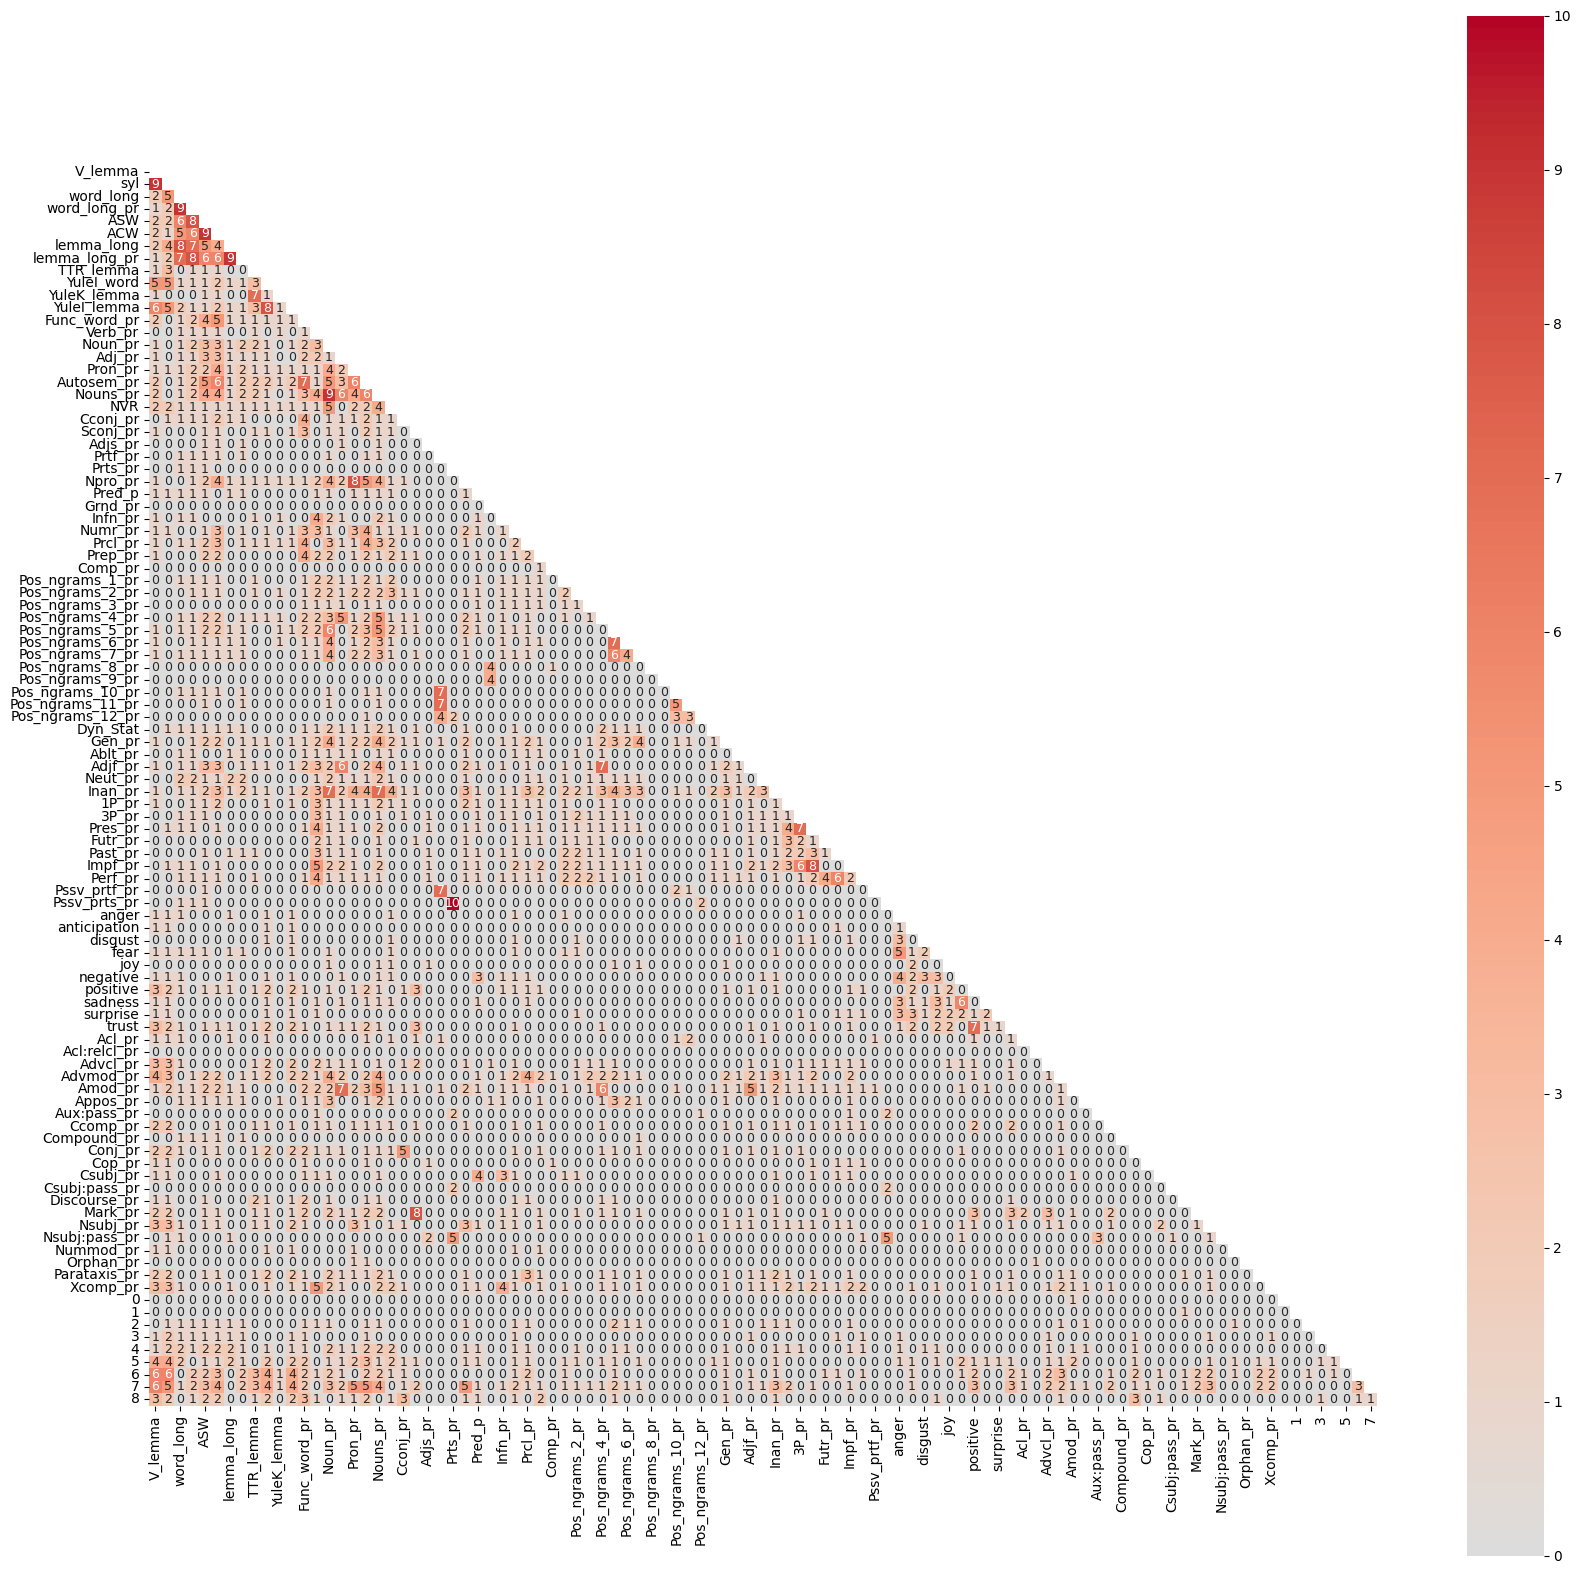

In [14]:
corr_whole = wholeDF[wholeDF.columns[3:]].corr(numeric_only=True)

drop_whole, mask_whole = cols2drop(corr_whole)

corr_whole = (corr_whole.abs() * 10).round()

plt.figure(figsize=(20, 20))
sns.heatmap(
    corr_whole,
    mask=mask_whole,
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.001,
    annot=True,
    annot_kws={"size": 9},
    cbar_kws={"ticks": [i for i in range(10 + 1)]},
)
plt.savefig(
    r"C:\Users\Ivan\Desktop\AI\0_Dissertation\CorrHeatmapWhole.png", bbox_inches="tight"
)

In [15]:
drop_whole

['Prts_pr']

In [16]:
wholeDF = wholeDF.drop(drop_whole, axis=1)

In [17]:
wholeDF[wholeDF.columns[3:]] = std_scaler.fit_transform(wholeDF[wholeDF.columns[3:]])
wholeDF.head().style.map(_df_colors)

,IDs,Primary Emotion,Emotion Class,V_lemma,syl,word_long,word_long_pr,ASW,ACW,lemma_long,lemma_long_pr,TTR_lemma,YuleI_word,YuleK_lemma,YuleI_lemma,Func_word_pr,Verb_pr,Noun_pr,Adj_pr,Pron_pr,Autosem_pr,Nouns_pr,NVR,Cconj_pr,Sconj_pr,Adjs_pr,Prtf_pr,Npro_pr,Pred_p,Grnd_pr,Infn_pr,Numr_pr,Prcl_pr,Prep_pr,Comp_pr,Pos_ngrams_1_pr,Pos_ngrams_2_pr,Pos_ngrams_3_pr,Pos_ngrams_4_pr,Pos_ngrams_5_pr,Pos_ngrams_6_pr,Pos_ngrams_7_pr,Pos_ngrams_8_pr,Pos_ngrams_9_pr,Pos_ngrams_10_pr,Pos_ngrams_11_pr,Pos_ngrams_12_pr,Dyn_Stat,Gen_pr,Ablt_pr,Adjf_pr,Neut_pr,Inan_pr,1P_pr,3P_pr,Pres_pr,Futr_pr,Past_pr,Impf_pr,Perf_pr,Pssv_prtf_pr,Pssv_prts_pr,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,Acl_pr,Acl:relcl_pr,Advcl_pr,Advmod_pr,Amod_pr,Appos_pr,Aux:pass_pr,Ccomp_pr,Compound_pr,Conj_pr,Cop_pr,Csubj_pr,Csubj:pass_pr,Discourse_pr,Mark_pr,Nsubj_pr,Nsubj:pass_pr,Nummod_pr,Orphan_pr,Parataxis_pr,Xcomp_pr,0,1,2,3,4,5,6,7,8
0,0107635181_00__00-channel-0-number-004_18310,С,1,-0.511976,-0.757821,-0.934699,-0.887960,-0.415000,-0.209181,-0.729870,-0.693324,0.737978,-0.450444,-0.397389,-0.519498,-0.521301,1.049052,1.051932,-0.504344,-0.180310,0.588051,0.627648,0.291631,-0.566402,-0.382525,-0.157769,-0.090390,-1.101779,-0.336044,-0.049876,-0.474333,-0.313618,-0.880123,0.845034,-0.130915,-0.322514,2.508260,-0.325305,1.974228,-0.302616,-0.124013,-0.216107,-0.023885,-0.016910,-0.056809,-0.049919,-0.032772,-0.349924,-0.594433,-0.227316,0.984686,-0.319326,1.545288,-0.456909,3.607456,2.818665,-0.281436,-0.595738,2.412246,-0.600571,-0.077452,-0.114444,-0.247501,-0.275469,-0.229150,-0.341319,-0.149972,-0.523135,-0.653947,-0.330047,-0.203878,-0.555541,-0.134329,-0.058671,2.547619,-1.427045,-0.450432,-0.175915,-0.058671,-0.205699,-0.016910,-0.435656,-0.194099,-0.262191,-0.033835,-0.269587,-0.409337,-1.671504,-0.134329,-0.115437,-0.050789,-0.425393,-0.573169,-0.023918,-0.123514,-0.270227,-0.545814,1.879909,-0.481925,-0.323405,-1.307088,1.081756
1,0107635181_00__00-channel-0-number-005_22100,С,1,0.915313,0.924972,1.164548,0.616108,0.395048,0.144233,0.600555,0.251882,-0.144567,-0.450444,-0.397389,-0.519498,-1.029965,0.591747,-0.586783,-0.504344,1.223285,-0.495506,-0.726904,-0.463123,0.713614,-0.382525,-0.157769,-0.090390,0.409021,-0.336044,-0.049876,-0.474333,-0.313618,-0.880123,-0.854840,-0.130915,-0.322514,-0.433789,1.710326,0.862406,-0.302616,-0.124013,-0.216107,-0.023885,-0.016910,-0.056809,-0.049919,-0.032772,-0.349924,-0.594433,-0.227316,0.235113,-0.319326,-0.324987,1.032227,1.733284,1.209630,1.518862,-0.595738,0.911995,0.413735,-0.077452,-0.114444,3.516671,3.203193,-0.229150,2.508167,-0.149972,1.281525,0.840179,-0.330047,-0.203878,1.187313,-0.134329,-0.058671,-0.392523,0.700749,-0.450432,-0.175915,-0.058671,-0.205699,-0.016910,-0.435656,-0.194099,-0.262191,-0.033835,-0.269587,-0.409337,0.598264,-0.134329,-0.115437,-0.050789,-0.425393,1.744686,-0.023918,-0.123514,-0.270227,-0.545814,-0.759434,0.309889,0.224691,0.424804,1.081756
2,0107635181_00__00-channel-0-number-006_26690,С,1,1.272135,0.160066,-0.934699,-0.887960,-1.335509,-1.019088,-0.729870,-0.693324,-0.071022,2.396651,-0.144658,2.358111,1.157289,-0.837333,-0.074685,1.437475,-0.774139,-0.263315,0.627648,1.423764,-0.566402,-0.382525,-0.157769,4.955213,-0.409329,-0.336044,-0.049876,-0.474333,-0.313618,-0.205854,1.694971,4.618698,-0.322514,-0.433789,-0.325305,0.751224,-0.302616,-0.124013,-0.216107,-0.023885,-0.016910,-0.056809,-0.049919,-0.032772,-0.498745,-0.594433,-0.227316,0.160156,-0.319326,0.259474,-0.456909,-0.515723,-0.721212,-0.281436,-0.595738,-0.888306,-0.600571,7.500797,-0.114444,-0.247501,-0.275469,4.127193,2.508167,-0.149972,3.086184,-0.653947,-0.330047,-0.203878,-0.555541,-0.134329,-0.058671,-0.392523,0.700749,2.220093,-0.175915,-0.058671,-0.205699,-0.016910,-0.435656,-0.194099,-0.262191,-0.033835,-0.269587,-0.409337,0.598264,-0.134329,-0.115437,-0.050789,2.350770,-0.573169,-0.023918,-0.123514,-0.270227,-0.545814,-0.759434,1.893518,0.224691,-0.152494,4.313166
3,010763696

In [18]:
X_train, X_test, y_train, y_test = train_test_split(wholeDF[wholeDF.columns[3:]], 
                                                    wholeDF["Emotion Class"], 
                                                    test_size=0.1, 
                                                    shuffle=True, 
                                                    random_state=42)

## Decision Tree

In [30]:
from time import time

In [31]:
start = time()
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X=X_train, y=y_train)
print(time() - start)
print("Test:")
print_metrics(dtc.predict(X_test), y_test, dtc.predict_proba(X_test))
print("\nTrain:")
print_metrics(dtc.predict(X_train), y_train, dtc.predict_proba(X_train))

0.3021819591522217
Test:
MSE: 20.428571428571427
Accuracy: 0.2714285714285714
F-score: 0.2760570817257188
ROC-AUC: 0.50163069781769

Train:
MSE: 0.0
Accuracy: 1.0
F-score: 1.0
ROC-AUC: 1.0


In [20]:
for depth in [1, 2, 3, 4, 5, 6, 10, 15, 20, 50, 100, None]:
    dt = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt.fit(X_train, y_train)
    y_pred = dt.predict_proba(X_test)
    auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
    # print('%4s -> %.3f' % (depth, auc))
    print(f'{str(depth):>4} -> {auc:.3}')

   1 -> 0.49
   2 -> 0.523
   3 -> 0.518
   4 -> 0.531
   5 -> 0.561
   6 -> 0.559
  10 -> 0.51
  15 -> 0.518
  20 -> 0.512
  50 -> 0.502
 100 -> 0.502
None -> 0.502


In [91]:
parameters = {
    "criterion": ['gini', 'entropy', 'log_loss'],
    "max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None],
    "splitter": ['best', 'random'],
    # "min_samples_split": [2, 2.5, 3],
    # "min_samples_leaf": [1, 2, 2.5, 3], 
    # "min_weight_fraction_leaf": [0.0, 0.1, 1.0, 1.5, 2],
    "max_features": ["sqrt", "log2", None, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 1],
    # "max_leaf_nodes": [None, 1, 2, 5],
    "min_impurity_decrease": [0, 1, 2, 3],
    "class_weight": [None, "balanced"],
    # "ccp_alpha": [0, 1, 0.2, 2.5]
}

In [92]:
dec_tree = DecisionTreeClassifier(random_state=42)

In [93]:
dt_grid = GridSearchCV(estimator=dec_tree, 
                       param_grid=parameters,
                       scoring=None,
                       refit=True,
                       verbose=4,
                       pre_dispatch="2*n_jobs",
                    #    error_score=...,
                       return_train_score=False,
                       cv=5,
                       n_jobs=-1)
dt_grid.fit(X_train, y_train)

Fitting 5 folds for each of 5808 candidates, totalling 29040 fits


C:\Users\Ivan\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
2640 fits failed out of a total of 29040.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1323 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Ivan\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Ivan\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\Ivan\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py", line 638, in _validate_params
    vali

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced'],
                         'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None],
                         'max_features': ['sqrt', 'log2', None, 0, 0.1, 0.2,
                                          0.3, 0.4, 0.5, 0.6, 1],
                         'min_impurity_decrease': [0, 1, 2, 3],
                         'splitter': ['best', 'random']},
             verbose=4)

In [95]:
dt_grid.best_params_

{'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 3,
 'max_features': 0.4,
 'min_impurity_decrease': 0,
 'splitter': 'best'}

In [98]:
dec_tree = DecisionTreeClassifier(criterion="entropy", 
                                  splitter="best", 
                                  max_depth = 5, # я не понимаю, почему не 3
                                  min_samples_split = 2, 
                                  min_samples_leaf = 1, 
                                  min_weight_fraction_leaf = 0, 
                                  max_features = 0.4, 
                                  random_state = 42, 
                                  max_leaf_nodes = None, 
                                  min_impurity_decrease = 0, 
                                  class_weight = None, 
                                  ccp_alpha = 0
)

In [99]:
dec_tree.fit(X=X_train, y=y_train)
print("Test:")
print_metrics(dec_tree.predict(X_test), y_test, dec_tree.predict_proba(X_test))
print("\nTrain:")
print_metrics(dec_tree.predict(X_train), y_train, dec_tree.predict_proba(X_train))

Test:
MSE: 18.762857142857143
Accuracy: 0.45714285714285713
F-score: 0.3402638244960294
ROC-AUC: 0.6103462550041223

Train:
MSE: 16.524142312579414
Accuracy: 0.5212833545108005
F-score: 0.41395386676876444
ROC-AUC: 0.731131711478304


In [100]:
def show_conf_matrx(y_real: ArrayLike, y_preds: ArrayLike, classes: ArrayLike, title: str="") -> None:
    fig, ax = plt.subplots(figsize=(20, 20))
    ax.set_title(title)
    cm_rfc = confusion_matrix(y_real, y_preds)
    disp_rfc = ConfusionMatrixDisplay(cm_rfc, display_labels=[letter2emo[num2emo[klas]] for klas in classes])
    disp_rfc.plot(include_values=True, cmap="viridis", ax=ax, colorbar=True)

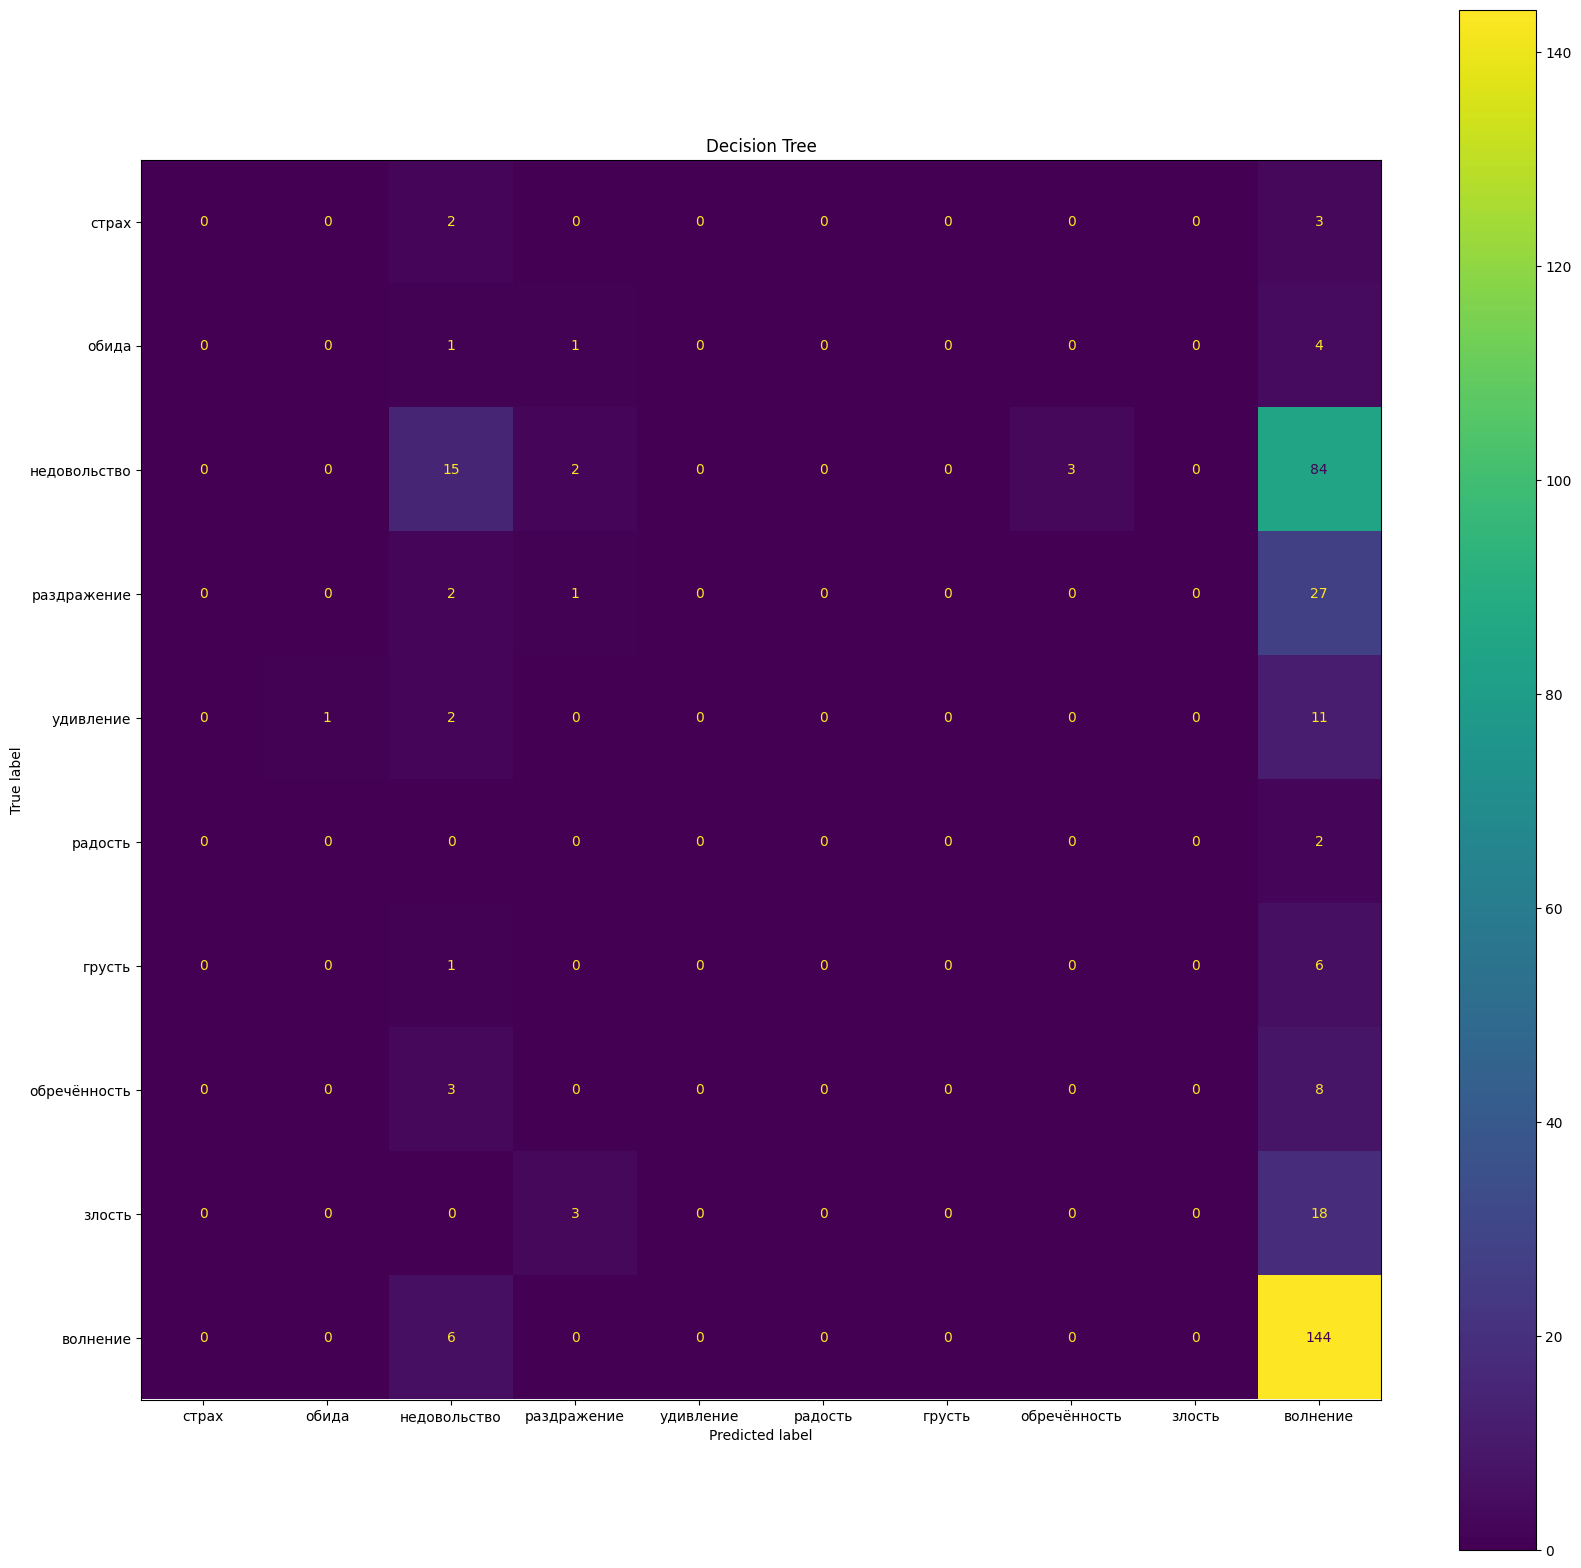

In [101]:
show_conf_matrx(y_test, dec_tree.predict(X_test), dec_tree.classes_, "Decision Tree")

## Random Forest

In [102]:
rfc = RandomForestClassifier(n_estimators=1000,
                             criterion="gini",
                             max_depth=10, 
                             min_samples_split=2,
                             min_samples_leaf=1,
                             min_weight_fraction_leaf=0,
                             max_features="sqrt",
                             max_leaf_nodes=None,
                             min_impurity_decrease=0,
                             bootstrap=True,
                             oob_score=False,
                             n_jobs=-1,
                             random_state=42,
                             verbose=0,
                             warm_start=False,
                             class_weight=None,
                             ccp_alpha=0,
                             max_samples=None
)
rfc.fit(X=X_train, y=y_train)

print("Test:")
print_metrics(rfc.predict(X_test), y_test, rfc.predict_proba(X_test))
print("\nTrain:")
print_metrics(rfc.predict(X_train), y_train, rfc.predict_proba(X_train))

Test:
MSE: 20.937142857142856
Accuracy: 0.43714285714285717
F-score: 0.29621118550512987
ROC-AUC: 0.6259689592090141

Train:
MSE: 12.113722998729353
Accuracy: 0.6254764930114358
F-score: 0.5445167412014779
ROC-AUC: 0.995026795081787


In [ ]:
# fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(30, 10))
# plt.subplots_adjust(hspace=0.5)
# fig.suptitle("Confusion matrices", fontsize=18, y=0.95)
# mcm_rfc = multilabel_confusion_matrix(y_test, rfc.predict(X_test), labels=rfc.classes_)

# for confusion_matrix, ax, klas in zip(mcm_rfc, axs.ravel(), rfc.classes_):
#     disp = ConfusionMatrixDisplay(confusion_matrix, display_labels=[letter2emo[num2emo[klas]], "other"])
#     disp.plot(include_values=True, cmap="viridis", ax=ax, xticks_rotation="vertical")

# plt.show()

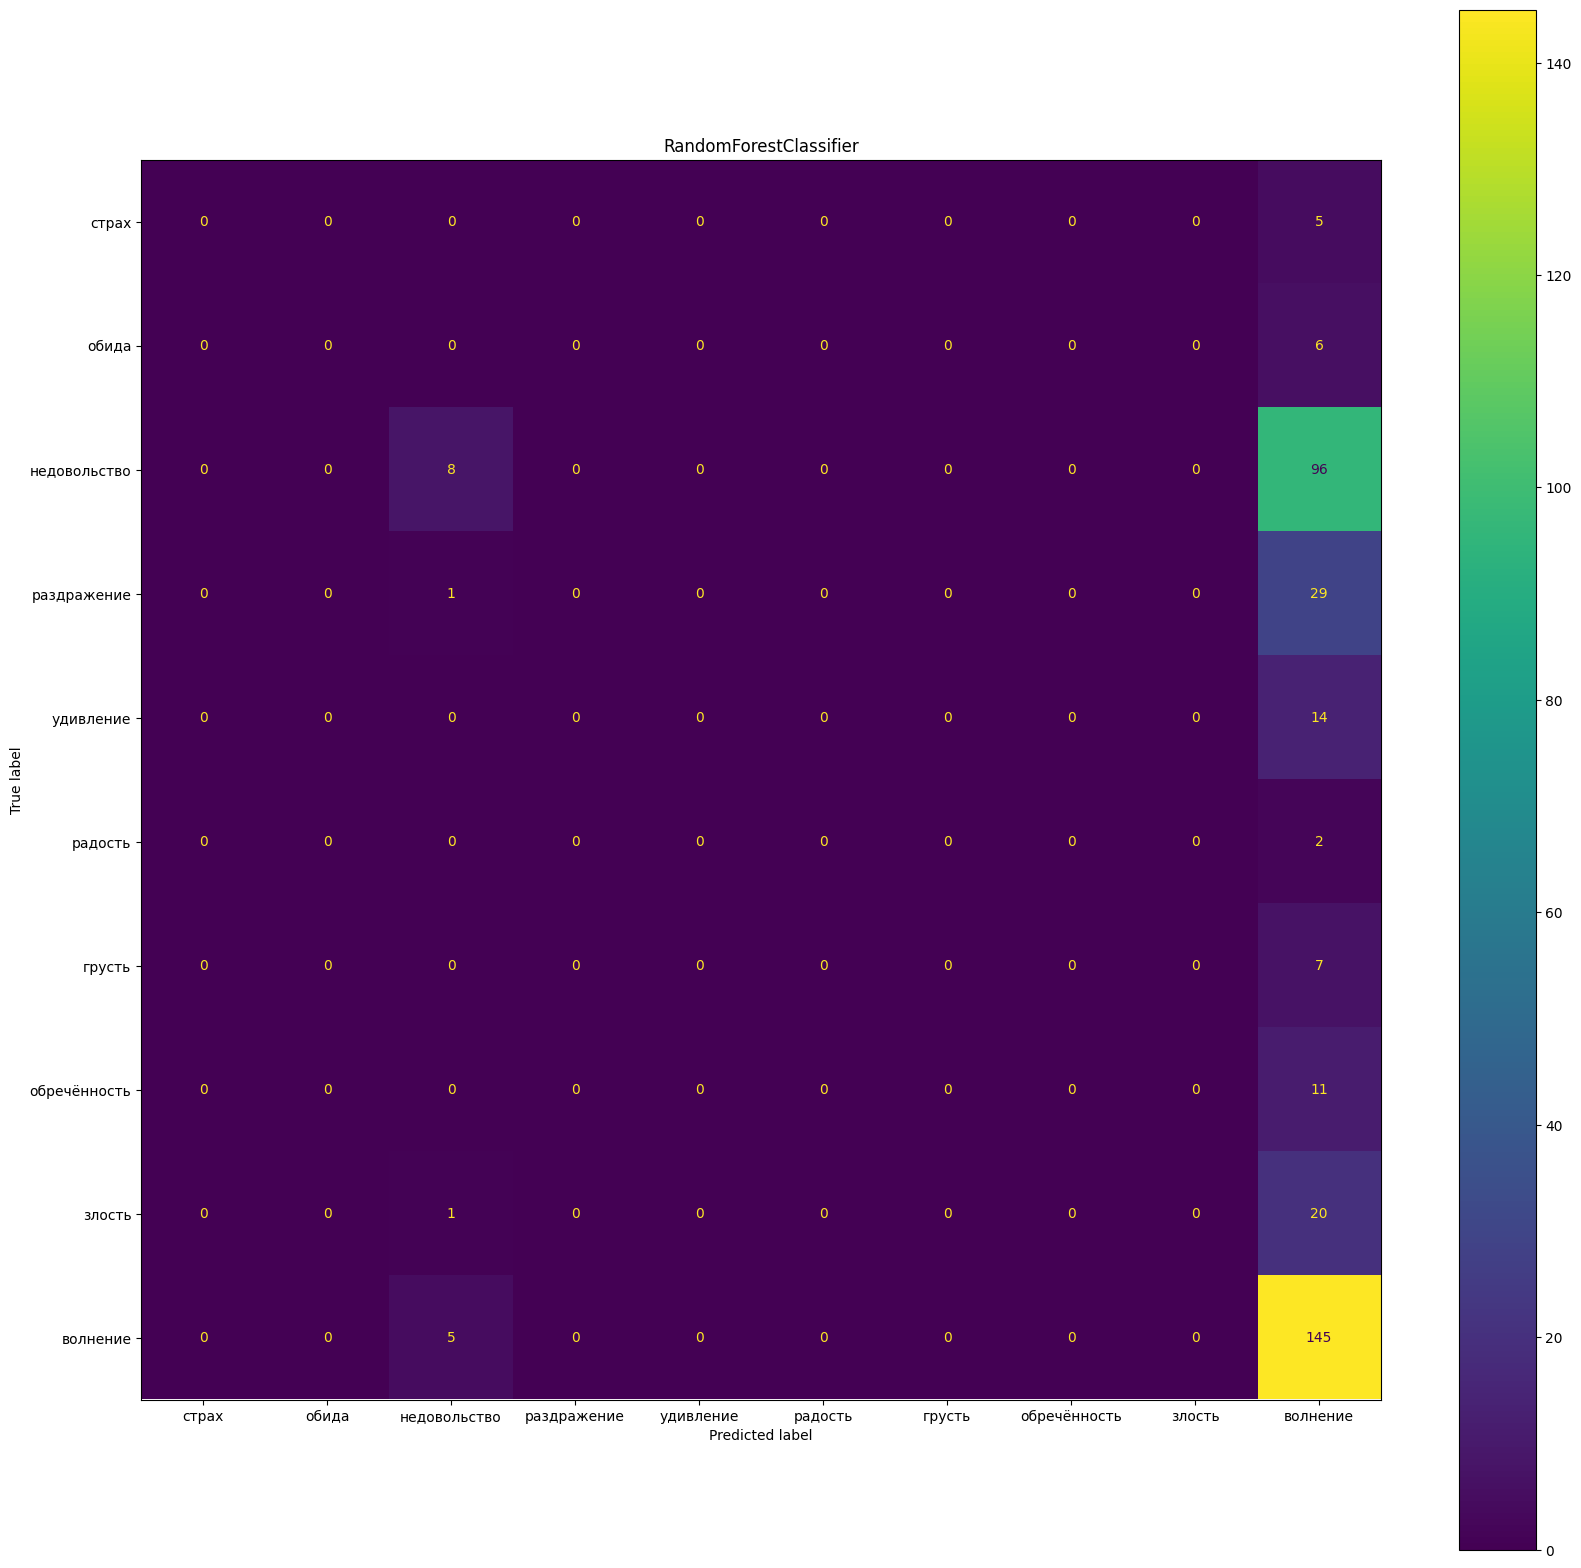

In [ ]:
show_conf_matrx(y_test, rfc.predict(X_test), rfc.classes_, "RandomForestClassifier")

## CatBoost

In [ ]:
cbc = CatBoostClassifier()

cbc.fit(X_train, y_train)
preds_class = cbc.predict(X_test)
print_metrics(preds_class, y_test, cbc.predict_proba(X_test))

Learning rate set to 0.083892
0:	learn: 2.1425607	total: 233ms	remaining: 3m 52s
1:	learn: 2.0270223	total: 276ms	remaining: 2m 17s
2:	learn: 1.9401833	total: 310ms	remaining: 1m 42s
3:	learn: 1.8704842	total: 342ms	remaining: 1m 25s
4:	learn: 1.8142929	total: 382ms	remaining: 1m 16s
5:	learn: 1.7666433	total: 422ms	remaining: 1m 9s
6:	learn: 1.7268848	total: 453ms	remaining: 1m 4s
7:	learn: 1.6929474	total: 493ms	remaining: 1m 1s
8:	learn: 1.6643863	total: 534ms	remaining: 58.8s
9:	learn: 1.6390676	total: 562ms	remaining: 55.6s
10:	learn: 1.6150585	total: 592ms	remaining: 53.2s
11:	learn: 1.5940420	total: 618ms	remaining: 50.9s
12:	learn: 1.5758173	total: 646ms	remaining: 49s
13:	learn: 1.5596374	total: 675ms	remaining: 47.5s
14:	learn: 1.5458901	total: 707ms	remaining: 46.4s
15:	learn: 1.5333192	total: 737ms	remaining: 45.3s
16:	learn: 1.5217666	total: 762ms	remaining: 44.1s
17:	learn: 1.5107776	total: 788ms	remaining: 43s
18:	learn: 1.4997887	total: 813ms	remaining: 42s
19:	learn: 1

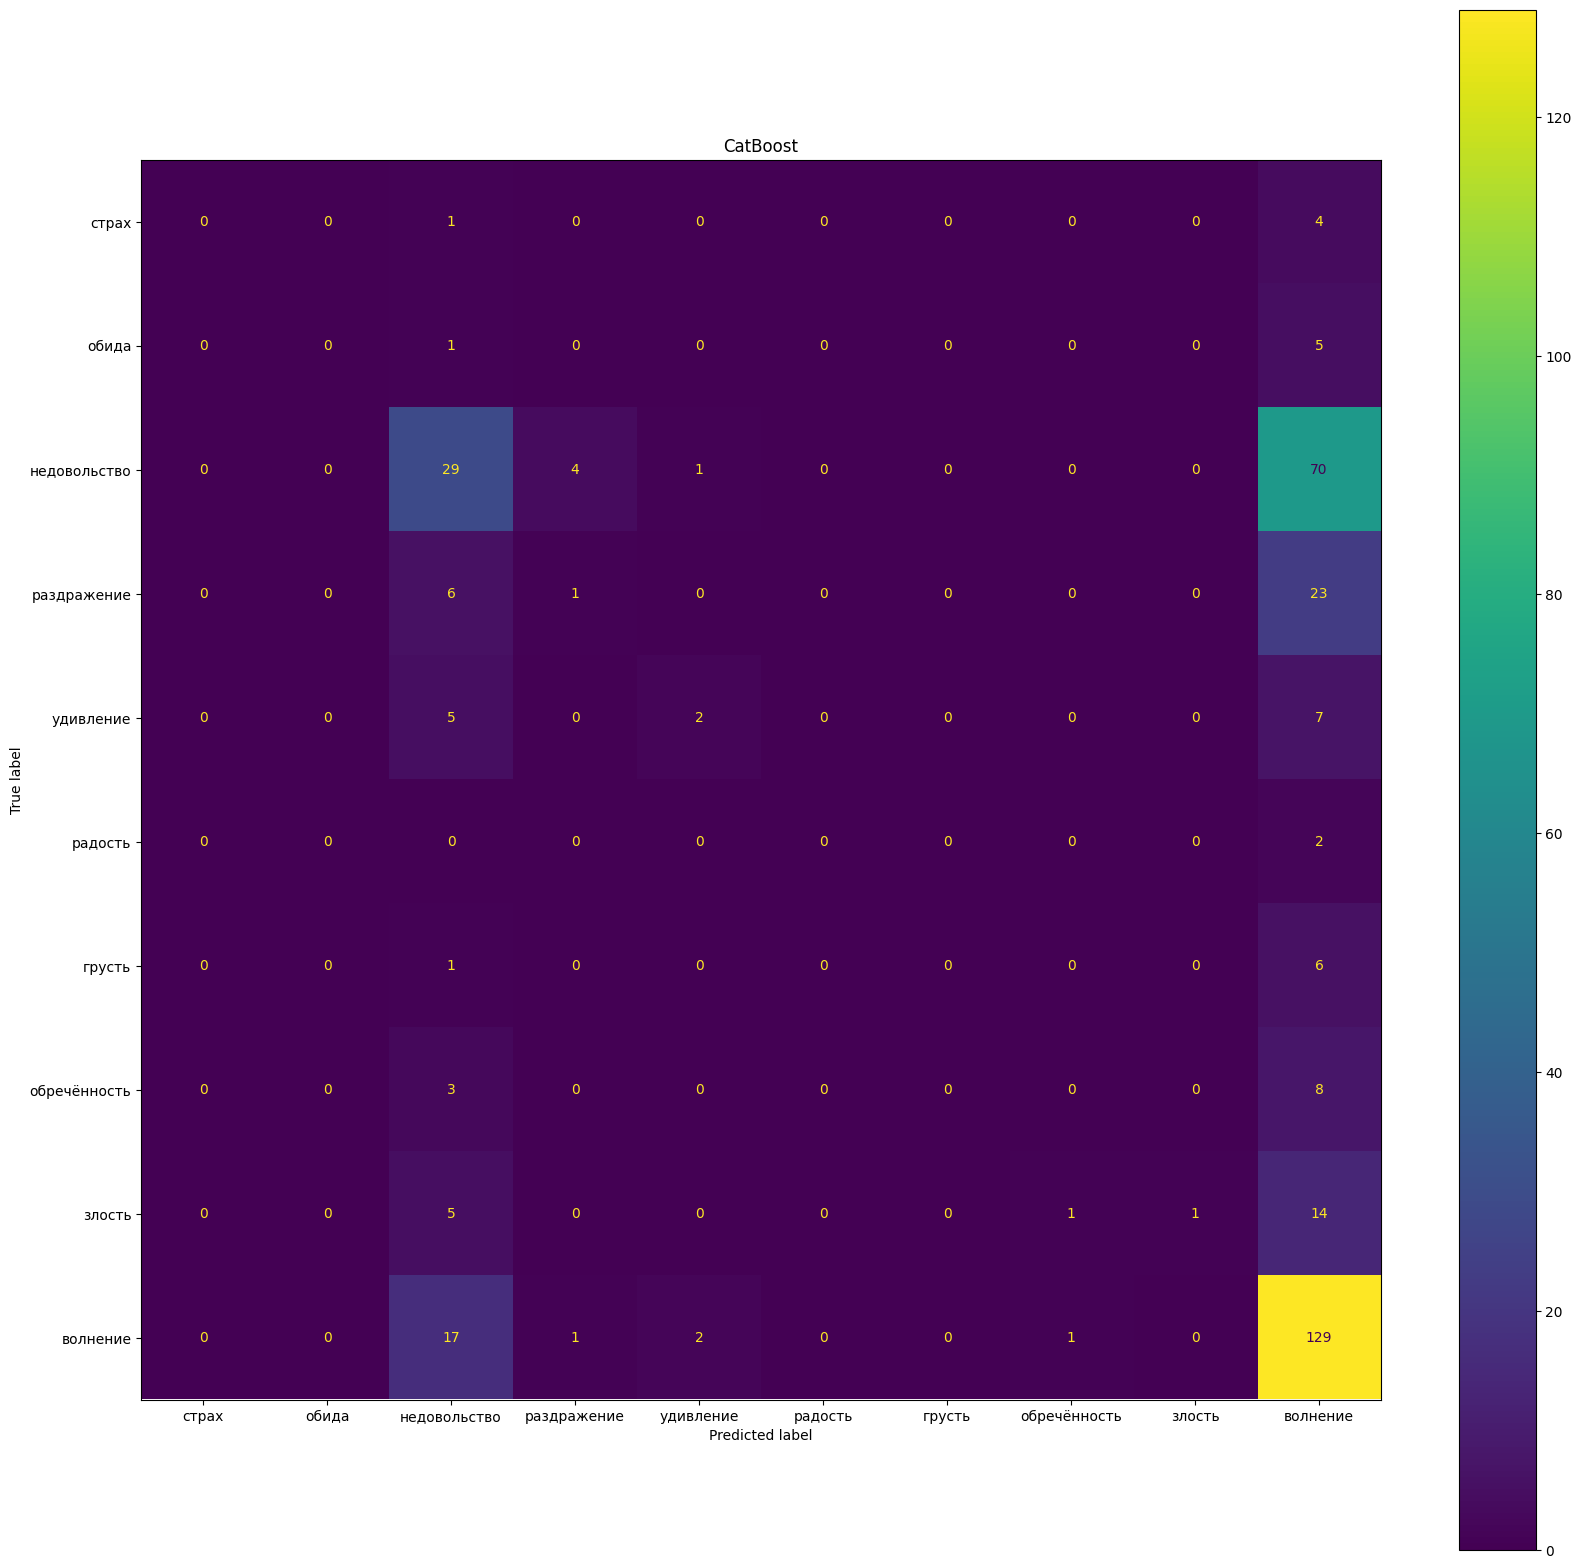

In [ ]:
show_conf_matrx(y_test, cbc.predict(X_test), cbc.classes_, "CatBoost")

## Gaussian Naive Bayes

In [ ]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)#.predict(X_test)

print_metrics(gnb.predict(X_test), y_test, gnb.predict_proba(X_test))

MSE: 32.254285714285714
Accuracy: 0.04
F-score: 0.019107395231310432
ROC-AUC: 0.6127727213276248


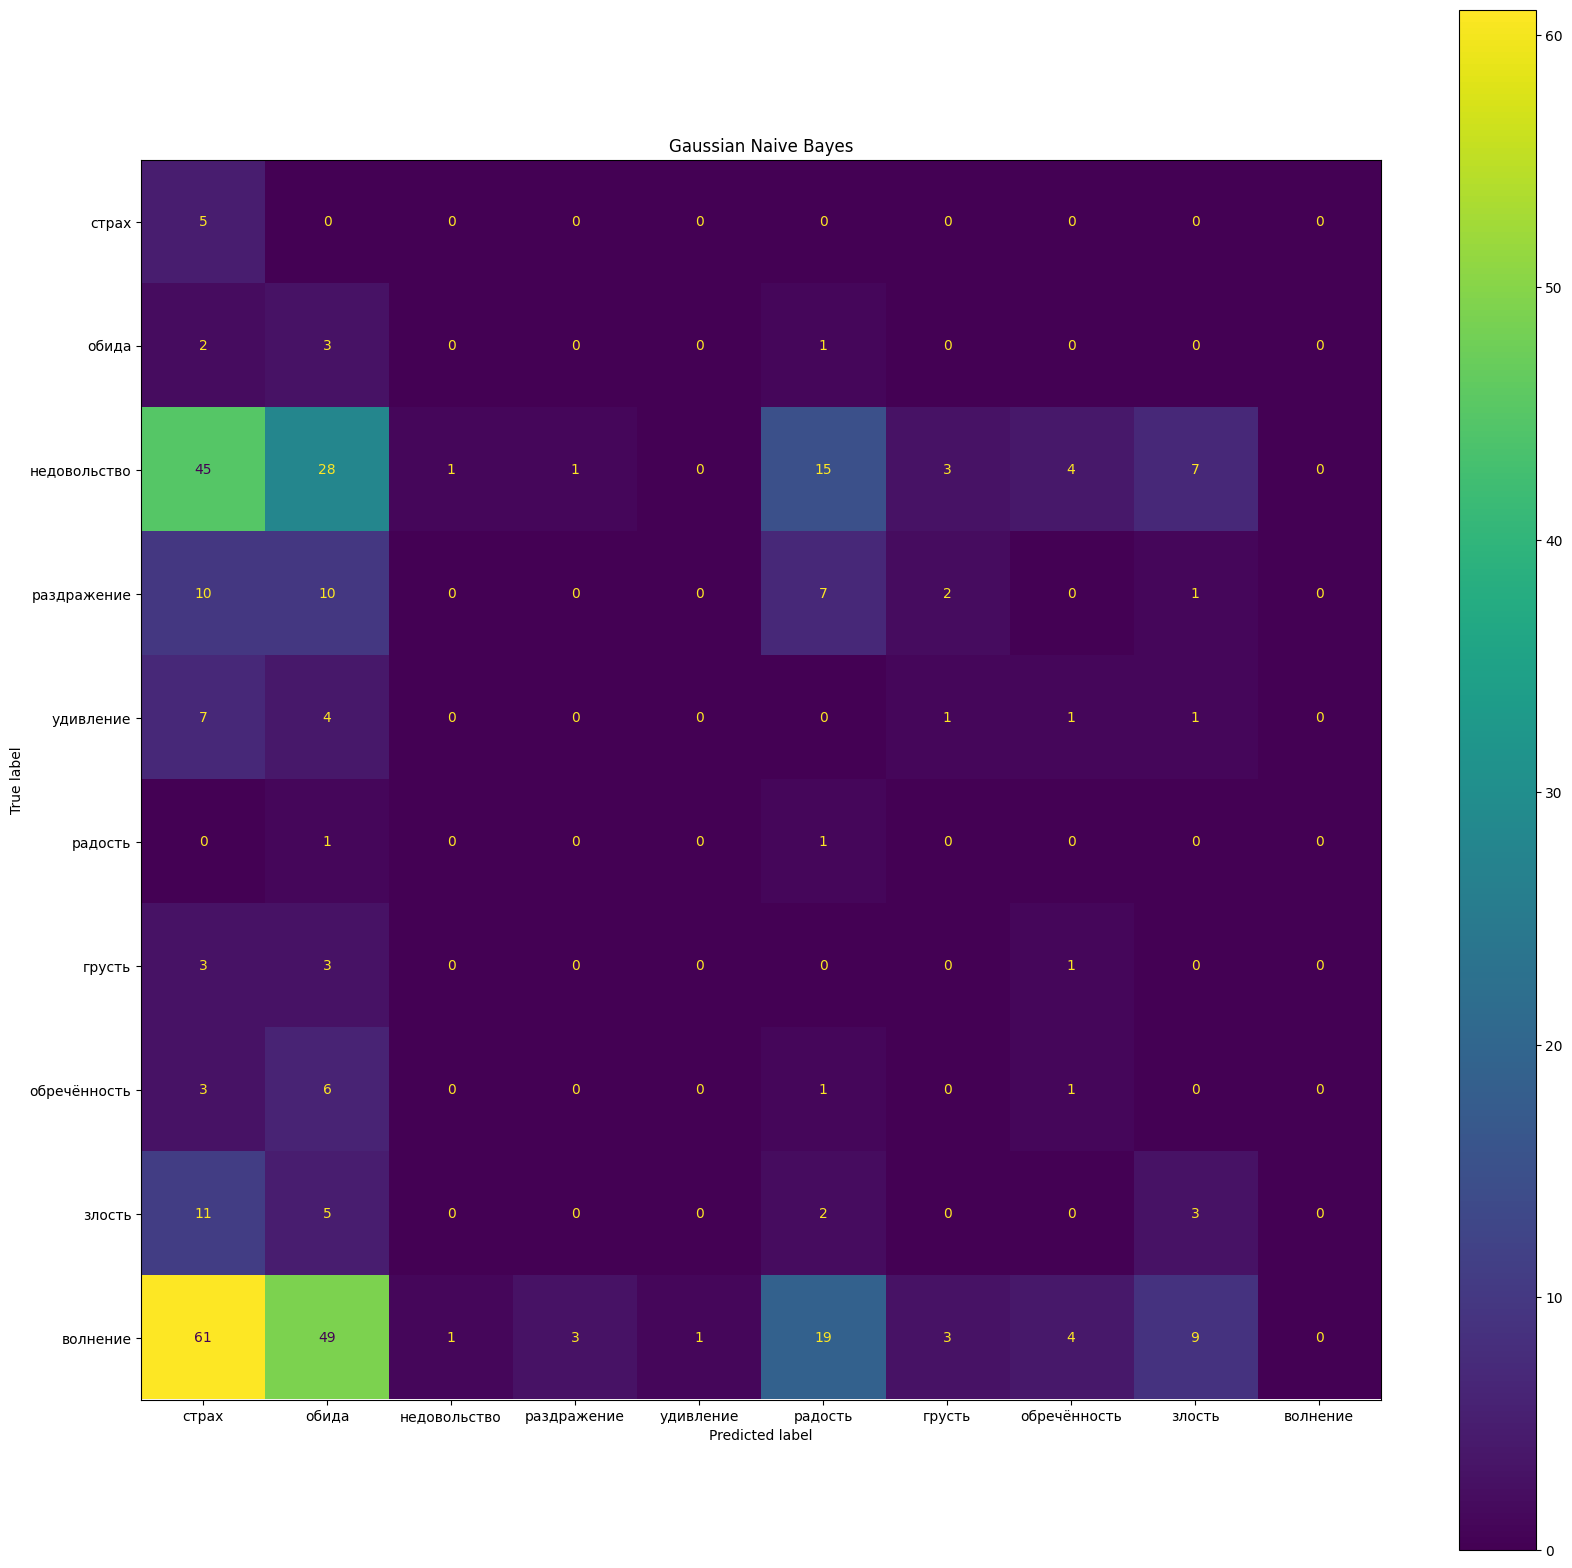

In [ ]:
show_conf_matrx(y_test, gnb.predict(X_test), gnb.classes_, "Gaussian Naive Bayes")

## K Nearest Neighbors

In [ ]:
knc = KNeighborsClassifier()

knc.fit(X=X_train, y=y_train)

print_metrics(knc.predict(X_test), y_test, knc.predict_proba(X_test))

MSE: 18.825714285714287
Accuracy: 0.39714285714285713
F-score: 0.35004853880444425
ROC-AUC: 0.5575450938372631


## Ridge (Linear classifiers) 

In [ ]:
ridge = RidgeClassifier()

ridge.fit(X=X_train, y=y_train)

print_metrics(ridge.predict(X=X_test), y=y_test)

MSE: 19.837142857142858
Accuracy: 0.44
F-score: 0.35127464618377363


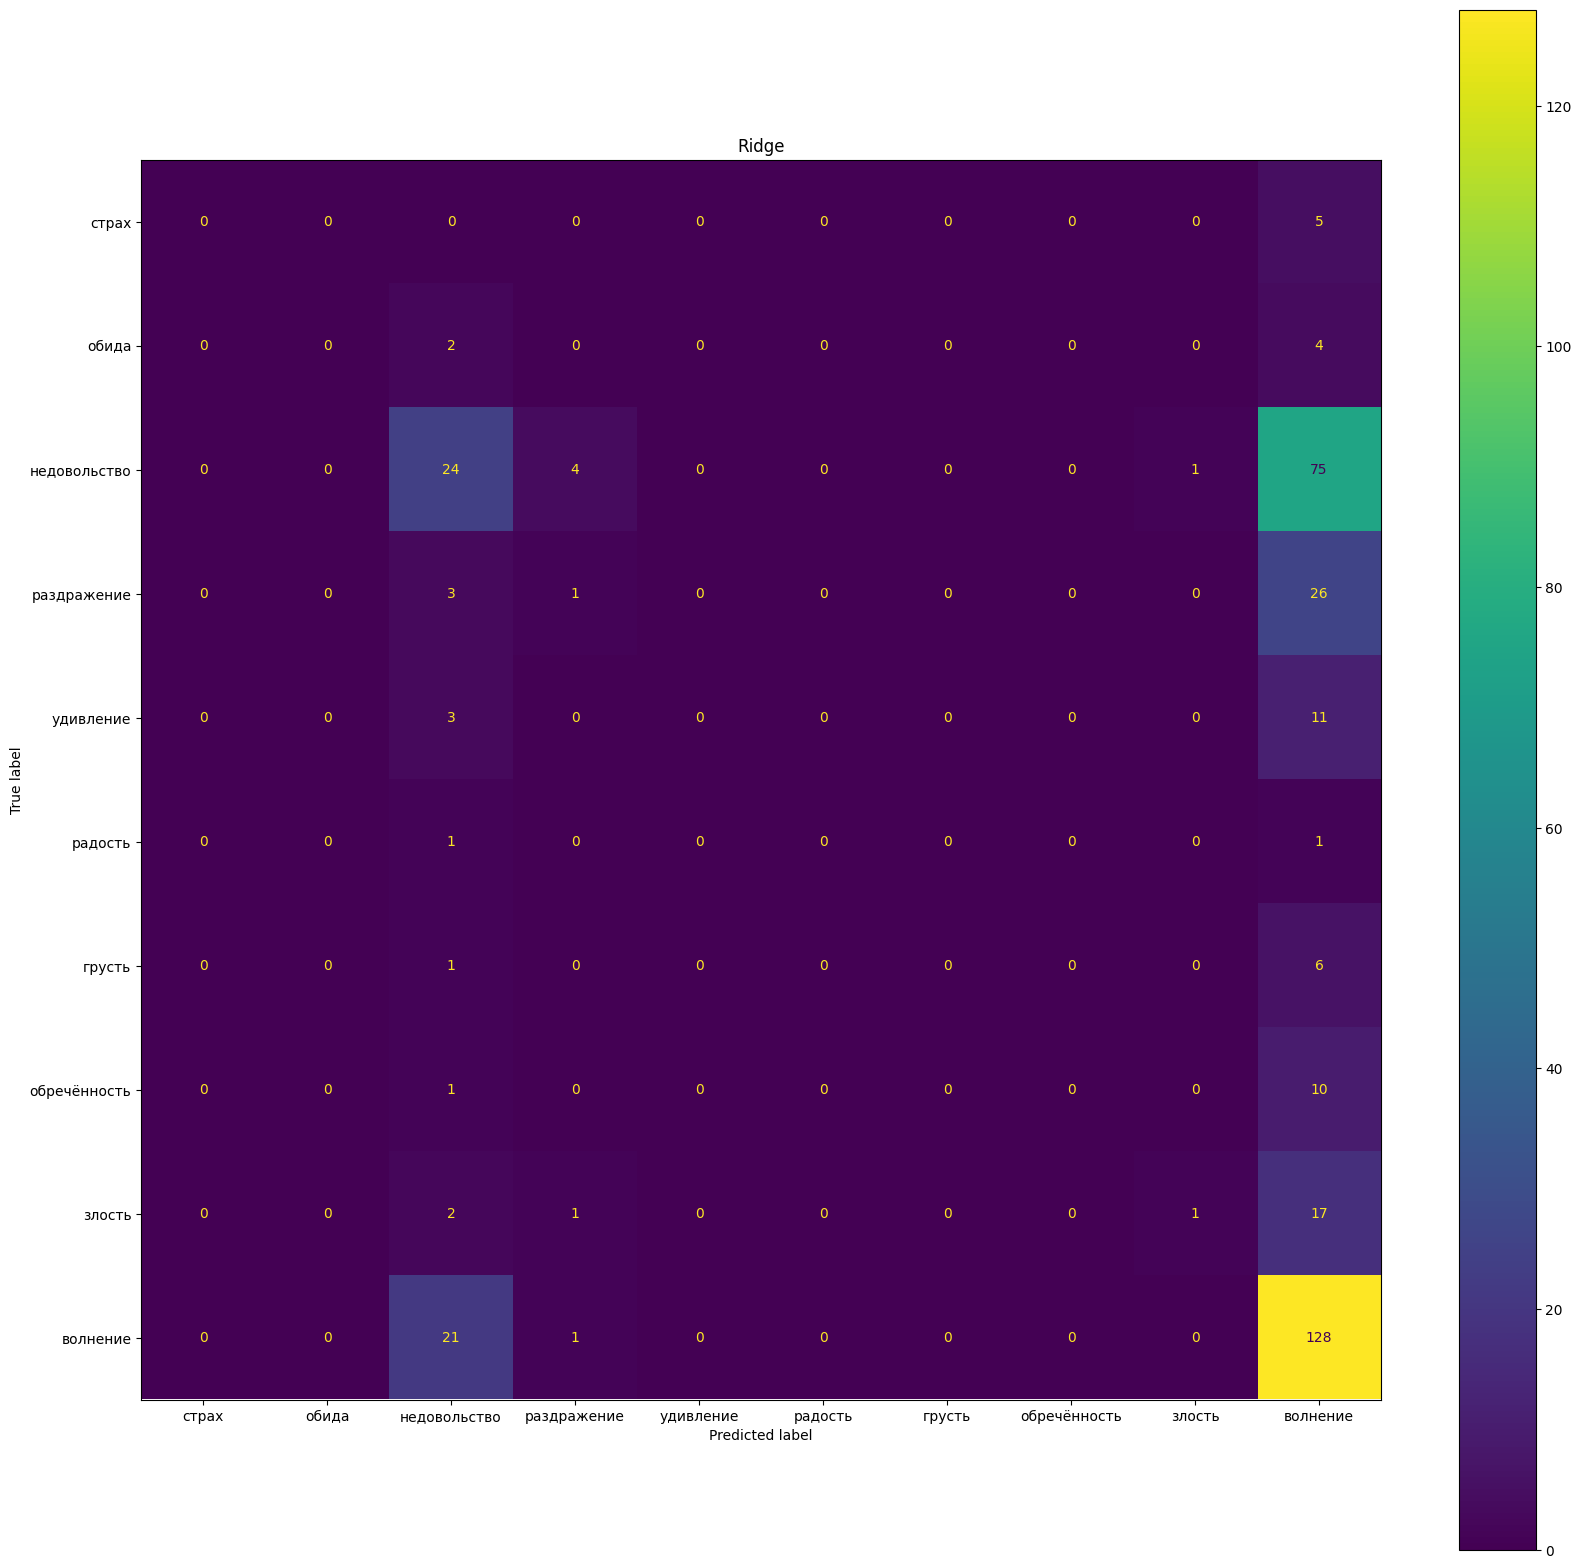

In [ ]:
show_conf_matrx(y_test, ridge.predict(X_test), ridge.classes_, "Ridge")

## Gaussian Process

In [ ]:
gpc = GaussianProcessClassifier(kernel=(1.0 * RBF(1.0)),
                                optimizer="fmin_l_bfgs_b",
                                n_restarts_optimizer=0,
                                max_iter_predict=100,
                                warm_start=False,
                                copy_X_train=True,
                                random_state=42,
                                multi_class="one_vs_rest", # "one_vs_one",
                                n_jobs=-1)
gpc.fit(X=X_train, y=y_train)

print_metrics(gpc.predict(X_test), y_test, gpc.predict_proba(X_test))

MSE: 21.357142857142858
Accuracy: 0.42857142857142855
F-score: 0.2571428571428571
ROC-AUC: 0.5497085685152714


## Support Vecs

In [ ]:
linSVM = SVC(kernel="linear", C=0.025, random_state=42, probability=True)
rbfSVM = SVC(gamma=2, C=1, random_state=42, probability=True)

In [ ]:
linSVM.fit(X=X_train, y=y_train)

print("Test:")
print_metrics(linSVM.predict(X_test), y_test, linSVM.predict_proba(X_test))
print("\nTrain:")
print_metrics(linSVM.predict(X_train), y_train, linSVM.predict_proba(X_train))

Test:
MSE: 21.60857142857143
Accuracy: 0.4228571428571429
F-score: 0.26004810004810003
ROC-AUC: 0.601418579323431

Train:
MSE: 17.724587039390087
Accuracy: 0.5022236340533672
F-score: 0.3413394457578908
ROC-AUC: 0.7421550938111007


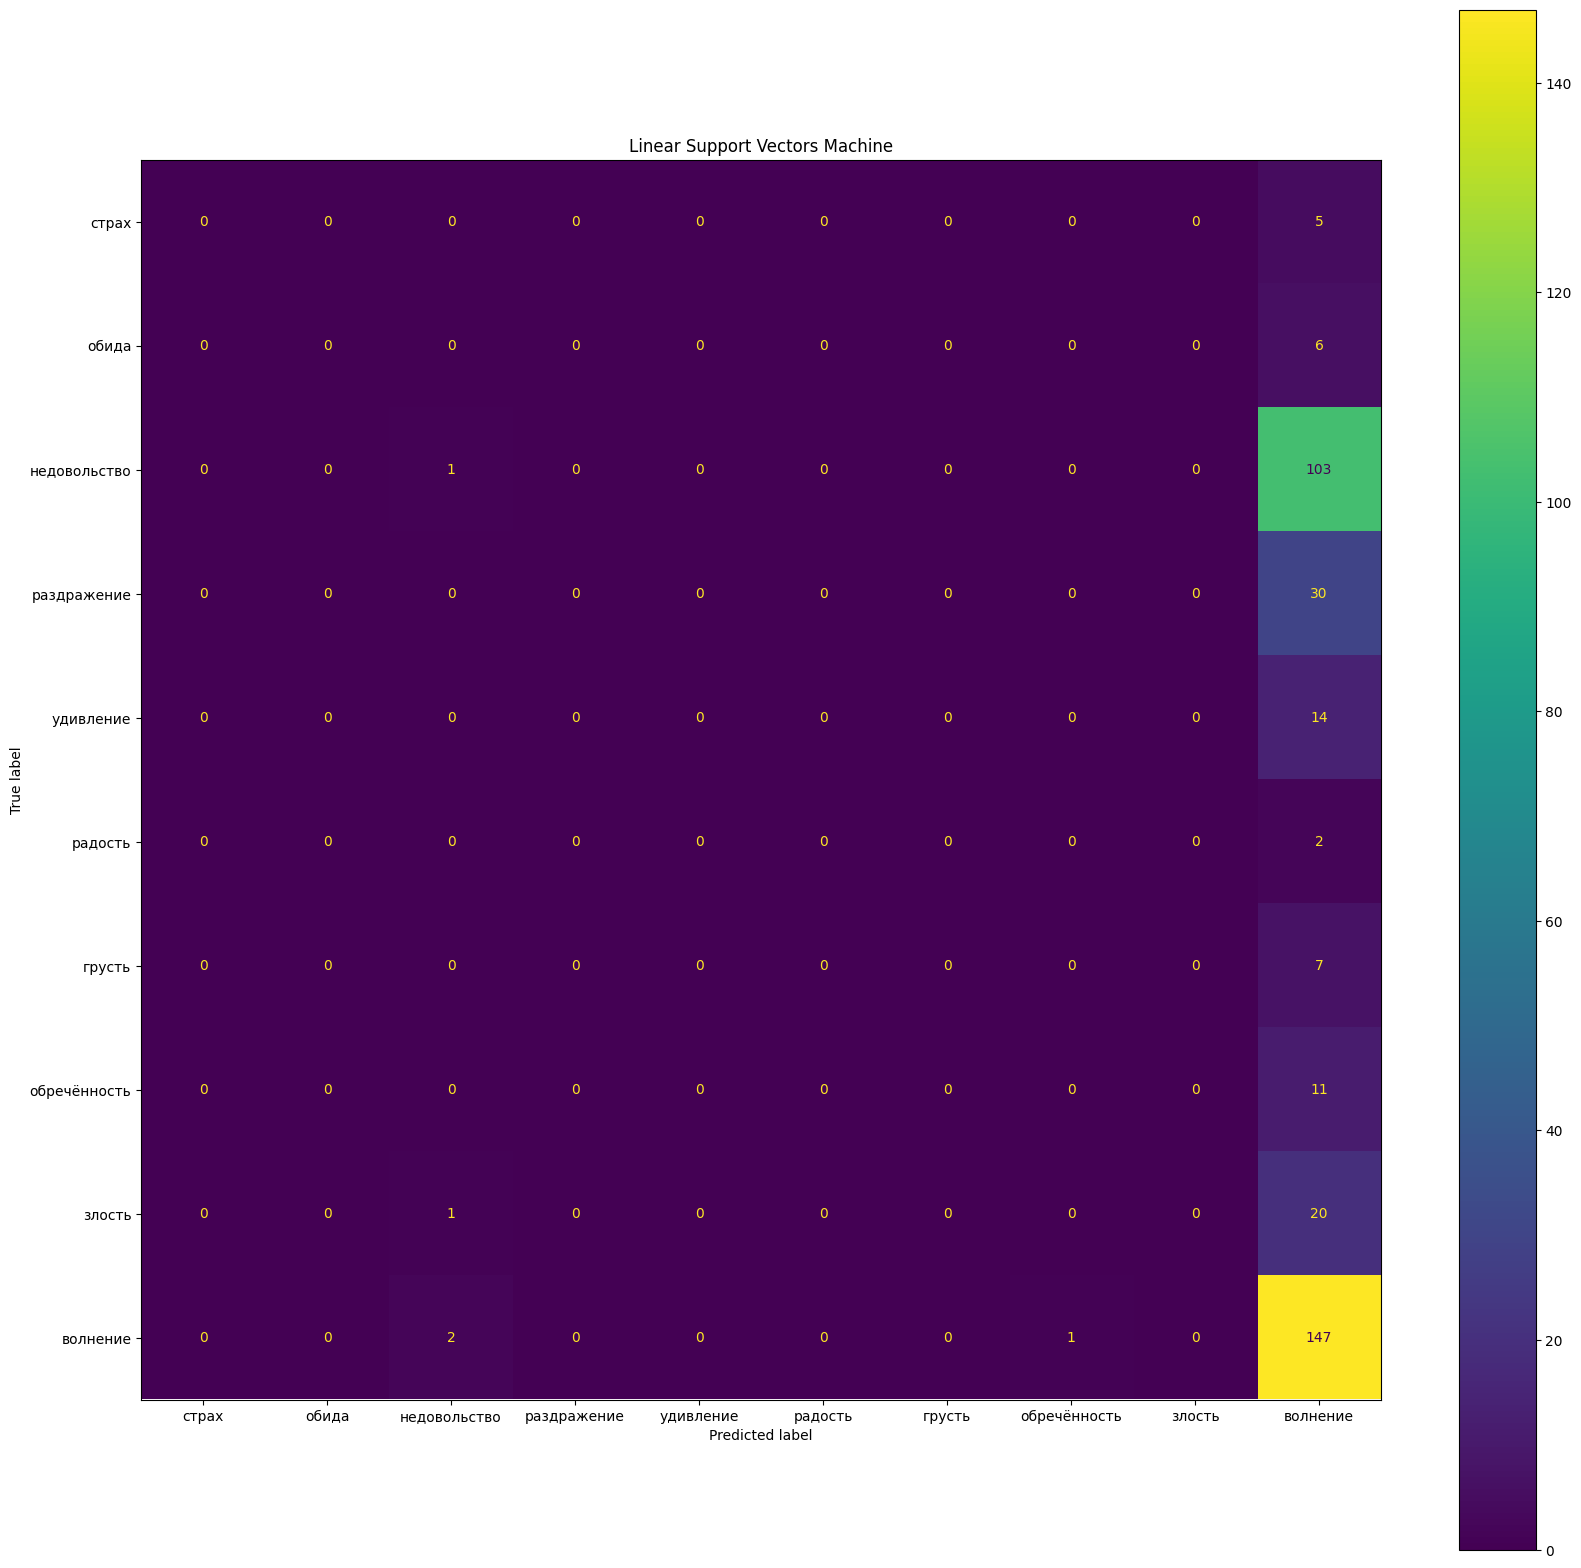

In [ ]:
show_conf_matrx(y_test, linSVM.predict(X_test), linSVM.classes_, "Linear Support Vectors Machine")

In [ ]:
rbfSVM.fit(X=X_train, y=y_train)

print("Test:")
print_metrics(rbfSVM.predict(X_test), y_test, rbfSVM.predict_proba(X_test))
print("\nTrain:")
print_metrics(rbfSVM.predict(X_train), y_train, rbfSVM.predict_proba(X_train))

Test:
MSE: 21.145714285714284
Accuracy: 0.4342857142857143
F-score: 0.26916875665929024
ROC-AUC: 0.48845359653388964

Train:
MSE: 0.0
Accuracy: 1.0
F-score: 1.0
ROC-AUC: 0.02258603407951888


## AdaBoost

In [ ]:
ada = AdaBoostClassifier()
ada.fit(X=X_train, y=y_train)

print("Test:")
print_metrics(ada.predict(X_test), y_test, ada.predict_proba(X_test))
print("\nTrain:")
print_metrics(ada.predict(X_train), y_train, ada.predict_proba(X_train))

Test:
MSE: 20.92
Accuracy: 0.4342857142857143
F-score: 0.2707572665429808
ROC-AUC: 0.5015985574698353

Train:
MSE: 17.92090216010165
Accuracy: 0.4936467598475222
F-score: 0.335520073930852
ROC-AUC: 0.6237637985666853
